In [1]:
%load_ext autoreload
%autoreload 2

from source.read_HAR_dataset import read_har_dataset, har_dimensions, har_activities, har_activities_map, har_ind_IDS
from source.utils import  filter_dimensions
from source.tserie import TSerie
from source.utils import classify_dataset
from itertools import chain, combinations
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import svm
from source.utils import idsStd
from sklearn import metrics
import numpy as np
from sklearn import svm
import umap
from imblearn.under_sampling import RandomUnderSampler
from source.augmentation import  * 
# from cuml.datasets import make_blobs
from cuml.neighbors import NearestNeighbors
from cuml.manifold import UMAP
from cuml.cluster import DBSCAN


sys.path.insert(0, '/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# Z_SCORE_NORM = True
NORM = 0 # 0: No normalization, 1: centering 2: z_score_norm
DATASET = 'HAR-UML20'
KFOLDS = 1
N_TESTS = 2
N_COMPONENTS = 32
METRIC  = 'braycurtis'
RESULTS_PATH = 'outputs/augmentation/'
# AUGMENTATIONS = ['rotation', 'permutation', 'time_warp', 'magnitude_warp', 'scaling', 'jitter']
# AUGMENTATIONS = ['none']
AUGMENTATIONS = ['scaling']
# ALL_AUGMENTATIONS = ['none', 'rotation', 'permutation', 'time_warp', 'magnitude_warp', 'scaling', 'jitter']
# ALL_AUGMENTATIONS = ['none', 'rotation', 'rotation', 'rotation', 'rotation', 'rotation', 'rotation']
ALL_AUGMENTATIONS = ['none'] * 7
# AUGMENTATIONS = ['magnitude_warp']
REPEATS_PER_AUGMENTATION = 1
INCLUDE_ORIGINAL = True
# N_DIMS_NAMES = ['Acc', 'Gyro', 'Mag']
N_DIMS_NAMES = ['Acc', 'Gyro']
# N_DIMS_NAMES = ['Acc']
N_DIMENSIONS = [
    [
        'Accelerometer-X',	
        'Accelerometer-Y',	
        'Accelerometer-Z',
    ],
    [
        'Gyrometer-X',
        'Gyrometer-Y',
        'Gyrometer-Z',
    ],
    # [
    #     'Magnetometer-X',
    #     'Magnetometer-Y',
    #     'Magnetometer-Z'
    # ]
]


In [2]:
class FeatureExtractor:
    def __init__(self, n_components, n_neighbors):
        self.reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, n_epochs=2000)
        self.nearNeigh = NearestNeighbors(n_neighbors=n_neighbors, metric=METRIC)

    def fit_transform(self, X, y=None):
        self.nearNeigh.fit(X)
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.fit_transform(X, y=y, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings
    
    def transform(self, X):
        knn_graph = self.nearNeigh.kneighbors_graph(X, mode="distance")
        embeddings =  self.reducer.transform(X, knn_graph=knn_graph.tocsr(), convert_dtype=True)
        return embeddings

def augmentData(X, y, augmentation, repeat = 3):
    X_out = []
    y_out = []
    for i in range(repeat):
        if augmentation == 'rotation':
            augmented = rotation(X, angle_range=[-np.pi/4, np.pi/4])
            # augmented = rotation(X, angle_range=[-np.pi/64, np.pi/64])
        elif augmentation == 'permutation':
            augmented = permutation(X)
        elif augmentation == 'time_warp':
            augmented = time_warp(X, sigma=0.03)
        elif augmentation == 'magnitude_warp':
            augmented = magnitude_warp(X, sigma=0.04, knot=4)
        elif augmentation == 'scaling':
            augmented = scaling(X, sigma=0.05)
        elif augmentation == 'jitter':
            augmented = jitter(X, sigma=0.01)
        # elif augmentation == 'magnitude_pert':
        #     augmented = magnitude_pert(X, prange=[0, 1])
        else:
            augmented = X
        if len(X_out) == 0:
            X_out = augmented
            y_out = y
        else:
            X_out = np.concatenate((X_out, augmented), axis=0)
            y_out = np.concatenate((y_out, y), axis=0)
    return X_out, y_out

def augment(X, y, augmentations, repeats_per_augmentation=1, include_original=False):
    X_aug = []
    y_aug = []
    if include_original:
        X_aug = X
        y_aug = y
    for augmentation in augmentations:
        curr_X_aug, curr_y_aug = augmentData(X, y, augmentation, repeat=repeats_per_augmentation)
        if len(X_aug) == 0:
            X_aug = curr_X_aug
            y_aug = curr_y_aug
        else:
            X_aug = np.concatenate((X_aug, curr_X_aug), axis=0)
            y_aug = np.concatenate((y_aug, curr_y_aug), axis=0)
    return X_aug, y_aug

def minoritySampling(X, y):
    rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
    N, T, D = X.shape
    X_temp = X.reshape([N, T * D])
    X_temp, y = rus.fit_resample(X_temp, y)
    X = X_temp.reshape([X_temp.shape[0], T, D])
    return X, y


activities_map = {
    0: "Sedentary",
    1: "Walking",
    2: "Running",
    3: "Downstairs",
    4: "Upstairs"
}
def load_data(k):
    all_ids = har_ind_IDS
    test_ids = all_ids[k: k + N_TESTS]
    train_ids = all_ids[:k] + all_ids[k + N_TESTS:]        
    
    data = read_har_dataset('./datasets/HAR-UML20/', train_ids=train_ids, test_ids=test_ids, val_ids=[], cache=True)
    ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']
    # ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']
    ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']
    
    

    all_dimensions = har_dimensions
    activities_map = har_activities_map
    
    y_train[y_train==0] = 0
    y_train[y_train==1] = 0
    y_train[y_train==2] = 0
    y_test[y_test==0] = 0
    y_test[y_test==1] = 0
    y_test[y_test==2] = 0

    for i in range(3, len(har_activities)):
        y_train[y_train==i] = i - 2
        y_test[y_test==i] = i - 2
    
    ind_std_train = idsStd(train_ids , X_train, I_train)
    ind_std_test = idsStd(test_ids, X_test, I_test)
    
    unique, counts = np.unique(y_train, return_counts=True)
    unique, counts = np.unique(y_test, return_counts=True)
    
    I_train = np.expand_dims(I_train, axis=1)
    I_test = np.expand_dims(I_test, axis=1)
    ltrain = np.arange(len(y_train))
    ltest = np.arange(len(y_test))
    
    X_train, zlabels_train = minoritySampling(X_train, ltrain)
    X_test, zlabels_test = minoritySampling(X_test, ltest)
    
    y_train = y_train[ltrain]
    I_train = I_train[ltrain]
    y_test = y_test[ltest]
    I_test = I_test[ltest]
    
    return X_train, y_train, I_train, X_test, y_test, I_test

In [3]:
# from source.torch_utils import getContrastiveFeatures
from sklearn.utils import shuffle

firstTimeSave = True
storage = MTSStorage('har_augmentations')
# storage.delete()
storage.load()


components_map = {}

for k in range(KFOLDS):
    print('FOLD: {}'.format(k))
    # ------------------------ Reading the dataset ------------------------
    X_train, y_train, I_train, X_test, y_test, I_test = load_data(k)
    # ---------------------------------------------------------------------

    
    train_embeddings = []
    train_ys = []
    test_embeddings = []
    
    augment_idx = []
    all_y = []
    cont = 0
    for aug in ALL_AUGMENTATIONS:
        if aug == 'none':
            idx_trans = np.random.choice(np.arange(len(y_train)), len(y_train), replace=False)
        else:
            n = len(y_train)
            nsize = len(y_train) // (len(ALL_AUGMENTATIONS) - 1)
            begin = cont * nsize
            end = (cont + 1) * nsize
            idx_trans = np.arange(len(y_train))[begin: end]
            # idx_trans = np.random.choice(np.arange(len(y_train_o)), , replace=False)
            cont = cont + 1
        # idx_trans = np.random.choice(np.arange(len(y_train_o)), len(y_train_o) // (len(ALL_AUGMENTATIONS)), replace=False)
        augment_idx.append(idx_trans)
        all_y.append(y_train[idx_trans])
        
    
    for t in range(len(N_DIMENSIONS)):
        dimensions = N_DIMENSIONS[t]    
        X_train_f = filter_dimensions(X_train, har_dimensions, dimensions)
        X_test_f = filter_dimensions(X_test, har_dimensions, dimensions)
        
        mts_train = TSerie(X = X_train_f, y = y_train, I = I_train, dimensions = dimensions, classLabels=activities_map)
        mts_test = TSerie(X = X_test_f, y = y_test, I = I_test, dimensions = dimensions, classLabels=activities_map)
        
        minl, maxl = mts_train.minMaxNormalization()
        mts_test.minMaxNormalization(minl=minl, maxl=maxl)
        
        
        # Saving augmentations
        test_tranformations = [
            augment(mts_test.X, mts_test.y, repeats_per_augmentation = 1, augmentations = [ALL_AUGMENTATIONS[i]], include_original = False)
            for i in range(len(ALL_AUGMENTATIONS))
        ]
        train_tranformations = [
            augment(mts_train.X, mts_train.y, repeats_per_augmentation = 1, augmentations = [ALL_AUGMENTATIONS[i]], include_original = False)
            for i in range(len(ALL_AUGMENTATIONS))
        ]
        
        # Training reducer
        if NORM == 1:
            mts_train.center()
            mts_test.center()
        elif NORM == 2:
            mts_train.znorm()
            mts_test.znorm()
        
        mts_train.folding_features_v2()
        mts_test.folding_features_v2()
        n_neighbors = 15
        reducer = FeatureExtractor(N_COMPONENTS, n_neighbors)        
        embeddings_train = reducer.fit_transform(mts_train.features, y=mts_train.y)
        embeddings_test = reducer.transform(mts_test.features)
        

        # Transforming augmentations        
        test_map = {}
        train_map = {}
        for i in range(len(ALL_AUGMENTATIONS)):
            tranformation_name = ALL_AUGMENTATIONS[i]
            
            # Testing
            test_tranformations[i] = test_tranformations[i][0].copy()
            train_tranformations[i] = train_tranformations[i][0].copy()
            
            mts_test_t = TSerie(X = test_tranformations[i], y = mts_test.y, I = mts_test.I, dimensions = dimensions, classLabels=activities_map)
            if NORM == 1:
                mts_test_t.center()
            elif NORM == 2:
                mts_test_t.znorm()
            mts_test_t.folding_features_v2()
            mts_test_t.features = reducer.transform(mts_test_t.features)
            test_map[ALL_AUGMENTATIONS[i]] = mts_test_t.features

            # Training
            idx = augment_idx[i]
            mts_train_t = TSerie(X = train_tranformations[i][idx], y = y_train[idx], I = I_train[idx], dimensions = dimensions, classLabels=activities_map)
            if NORM == 1:
                mts_train_t.center()
            elif NORM == 2:
                mts_train_t.znorm()
            mts_train_t.folding_features_v2()
            mts_train_t.features = reducer.transform(mts_train_t.features)
            train_map[ALL_AUGMENTATIONS[i]] = mts_train_t.features
        
        train_embeddings.append(train_map)
        test_embeddings.append(test_map)
        
        # embeddings_train, embeddings_test = getContrastiveFeatures(mts_train.X.transpose([0, 2, 1]), mts_train.y, epochs =20, loss_metric='SupConLoss', X_test=mts_test.X.transpose([0, 2, 1]))
            # if firstTimeSave:
                # print(np.random.random([test_tranformations[i].shape[0], 2]).shape)
                # storage.add_mts(
                #     'test {}_{}'.format(ALL_AUGMENTATIONS[i], N_DIMS_NAMES[t]),
                #     mts_test_t.X, 
                #     dimensions,
                #     coords={
                #         'umap': mts_test_t.features
                #     }, 
                #     labels={
                #         'activities': mts_test.y, 
                #         # 'participants': mts_test.I
                #     }, 
                #     labelsNames={'activities': activities_map },
                #     sampling = True,
                #     n_samples = 400
                # )
                # storage.add_mts(
                #     'train {}_{}'.format(ALL_AUGMENTATIONS[i], N_DIMS_NAMES[t]),
                #     mts_train_t.X, 
                #     dimensions,
                #     coords={
                #         'umap': mts_train_t.features
                #     }, 
                #     labels={
                #         'activities': mts_train_t.y, 
                #         # 'participants': mts_test.I
                #     }, 
                #     labelsNames={'activities': activities_map },
                #     sampling = True,
                #     n_samples = 400
                # )
                # storage.save()
            
    firstTimeSave = False
    
    names_comb = []
    embeddings_comb = []
    for i, combo in enumerate(powerset(list(range(len(N_DIMS_NAMES)))), 1):
        indexes = list(combo)
        name = ''
        train_embedding = {}
        # train_y = {}
        test_embedding = {}
        if len(indexes) == 0:
            continue
        for ind in indexes:
            name = name + ' ' + N_DIMS_NAMES[ind]
            if len(test_embedding) == 0:
                for aug in ALL_AUGMENTATIONS:
                    test_embedding[aug] = test_embeddings[ind][aug]
            else:
                for aug in ALL_AUGMENTATIONS:
                    test_embedding[aug] = np.concatenate([test_embedding[aug], test_embeddings[ind][aug]], axis=1)        

            if len(train_embedding) == 0:
                for aug in ALL_AUGMENTATIONS:
                    train_embedding[aug] = train_embeddings[ind][aug]
            else:
                for aug in ALL_AUGMENTATIONS:
                    train_embedding[aug] = np.concatenate([train_embedding[aug], train_embeddings[ind][aug]], axis=1)
        
        names_comb.append(name)
        embeddings_comb.append((train_embedding, test_embedding))
    
    print('Classifying')
    for j in range(len(names_comb)):
        name = names_comb[j]
        # clf = AdaBoostClassifier()
        clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
        # clf = svm.SVC()
        
        train_feat = []
        train_y = []
        
        train_feat_map, test_feat_map = embeddings_comb[j]
        for a in range(len(ALL_AUGMENTATIONS)):
            aug = ALL_AUGMENTATIONS[a]
            if(len(train_feat)) == 0:
                train_feat = train_feat_map[aug]
                train_y = all_y[a]
            else:
                train_feat = np.concatenate([train_feat, train_feat_map[aug]], axis = 0) 
                train_y = np.concatenate([train_y, all_y[a]], axis = 0) 
        # train_y = 
        clf.fit(train_feat, train_y)
        
        pred_train = clf.predict(train_feat)
        f1_tr = metrics.f1_score(train_y, pred_train, average='weighted')
        
        f1_scores = [f1_tr]
        
        for aug in ALL_AUGMENTATIONS:
            test_feat = test_feat_map[aug]
            pred_test = clf.predict(test_feat)
            f1_te = metrics.f1_score(y_test, pred_test, average='weighted')
            f1_scores.append(f1_te)
        
        if name not in components_map:
            components_map[name] = [f1_scores]
        else:
            components_map[name] = components_map[name] + [f1_scores]
    print('Classifying done')


        
    
    
    

FOLD: 0
Train IDS: [2, 3, 4, 5, 6, 7, 8, 9]
Test IDS: [0, 1]
Val IDS: []
Loading dataset from cache...


KeyboardInterrupt: 

In [ ]:
# train_embeddings[0]['rotation'][:2]

[' Acc', '0.307 (0.003)', '0.288 (0.012)', '0.288 (0.012)', '0.288 (0.012)', '0.288 (0.012)', '0.288 (0.012)', '0.288 (0.012)', '0.288 (0.012)']
[' Gyro', '0.325 (0.003)', '0.305 (0.021)', '0.305 (0.021)', '0.305 (0.021)', '0.305 (0.021)', '0.305 (0.021)', '0.305 (0.021)', '0.305 (0.021)']
[' Acc Gyro', '0.331 (0.003)', '0.327 (0.027)', '0.327 (0.027)', '0.327 (0.027)', '0.327 (0.027)', '0.327 (0.027)', '0.327 (0.027)', '0.327 (0.027)']


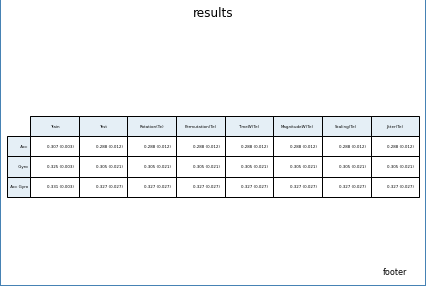

In [ ]:
import csv
from source.utils import plotMatResult

row_names = []
column_names = ['Train', 'Test', 'Rotation(Te)', 'Permutation(Te)', 'TimeW(Te)', 'MagnitudeW(Te)', 'Scaling(Te)', 'Jitter(Te)']
mat_data = []

path = os.path.join(RESULTS_PATH, 'Umap_kfold_{}.csv'.format('_'.join(AUGMENTATIONS)))
with open(path, 'w', newline='') as csvfile:
    row = ['Sensors', 'f1 train', 'f1 test']
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(row)
    for name in names_comb:
        row_names.append(name)
        row = [name]
        f1_mean_tr = np.array([ f1[0] for f1 in components_map[name]]).mean()
        f1_stds_tr = np.array([ f1[0] for f1 in components_map[name]]).std()
        f1_mean_te = np.array([ f1[1] for f1 in components_map[name]]).mean()
        f1_stds_te = np.array([ f1[1] for f1 in components_map[name]]).std()
        f1_mean_te_rot = np.array([ f1[2] for f1 in components_map[name]]).mean()
        f1_stds_te_rot = np.array([ f1[2] for f1 in components_map[name]]).std()
        f1_mean_te_per = np.array([ f1[3] for f1 in components_map[name]]).mean()
        f1_stds_te_per = np.array([ f1[3] for f1 in components_map[name]]).std()
        f1_mean_te_tim = np.array([ f1[4] for f1 in components_map[name]]).mean()
        f1_stds_te_tim = np.array([ f1[4] for f1 in components_map[name]]).std()
        f1_mean_te_mag = np.array([ f1[5] for f1 in components_map[name]]).mean()
        f1_stds_te_mag = np.array([ f1[5] for f1 in components_map[name]]).std()
        f1_mean_te_sca = np.array([ f1[6] for f1 in components_map[name]]).mean()
        f1_stds_te_sca = np.array([ f1[6] for f1 in components_map[name]]).std()
        f1_mean_te_jit = np.array([ f1[7] for f1 in components_map[name]]).mean()
        f1_stds_te_jit = np.array([ f1[7] for f1 in components_map[name]]).std()
        
        row = [
            name, 
            '{:.3f} ({:.3f})'.format(f1_mean_tr, f1_stds_tr), 
            '{:.3f} ({:.3f})'.format(f1_mean_te, f1_stds_te), 
            '{:.3f} ({:.3f})'.format(f1_mean_te_rot, f1_stds_te_rot), 
            '{:.3f} ({:.3f})'.format(f1_mean_te_per, f1_stds_te_per), 
            '{:.3f} ({:.3f})'.format(f1_mean_te_tim, f1_stds_te_tim), 
            '{:.3f} ({:.3f})'.format(f1_mean_te_mag, f1_stds_te_mag), 
            '{:.3f} ({:.3f})'.format(f1_mean_te_sca, f1_stds_te_sca), 
            '{:.3f} ({:.3f})'.format(f1_mean_te_jit, f1_stds_te_jit), 
        ]
        mat_data.append(row[1:])
        print(row)
        spamwriter.writerow(row)


plotMatResult('results', 'footer', row_names, column_names, mat_data, plot_fig=True, save_fig=True, file_name='umap_none.png')

In [ ]:
[' Acc', '0.755 (0.000)', '0.420 (0.000)', '0.435 (0.000)', '0.423 (0.000)', '0.360 (0.000)', '0.365 (0.000)', '0.430 (0.000)', '0.423 (0.000)']
[' Gyro', '0.769 (0.000)', '0.458 (0.000)', '0.461 (0.000)', '0.435 (0.000)', '0.446 (0.000)', '0.416 (0.000)', '0.453 (0.000)', '0.459 (0.000)']
[' Acc Gyro', '0.951 (0.000)', '0.600 (0.000)', '0.582 (0.000)', '0.570 (0.000)', '0.523 (0.000)', '0.479 (0.000)', '0.591 (0.000)', '0.594 (0.000)']

[' Acc Gyro',
 '0.951 (0.000)',
 '0.600 (0.000)',
 '0.582 (0.000)',
 '0.570 (0.000)',
 '0.523 (0.000)',
 '0.479 (0.000)',
 '0.591 (0.000)',
 '0.594 (0.000)']

In [ ]:
'Rotation 0.999 (0.001)', '0.955 (0.027)'

('Rotation 0.999 (0.001)', '0.955 (0.027)')

In [ ]:
'Original Acc', '0.998 (0.001)', '0.925 (0.045)'

('Original Acc', '0.998 (0.001)', '0.925 (0.045)')